# RNA-Seq Analysis Training Demo

In [1]:
system("sudo chmod -R a+rwx /usr/lib/R/library")

### STEP 1: Library Installation

First install the R packages that will be used. <strong>This installation may take around 15 minutes.</strong>

In [2]:
###install the libraries first, if required
install.packages("BiocManager")

if (!require("ComplexHeatmap"))
    BiocManager::install("ComplexHeatmap")

if (!require("DESeq2"))
    BiocManager::install("DESeq2")

if (!require("EnhancedVolcano"))
    BiocManager::install('EnhancedVolcano')

if (!require("dplyr"))
    install.packages("dplyr")

if (!require("pheatmap"))
    install.packages("pheatmap")

if (!require("ggrepel"))
    install.packages("ggrepel")

if (!require("ggfortify"))
    install.packages("ggfortify")


###load the libraries
library(DESeq2)
library(dplyr)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(ggplot2)
library(ggrepel)
library(ggfortify)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: DESeq2

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Atta

In [3]:
library("DESeq2")

### STEP 2: Downloading Data

First we need to download the readcounts we produced in the previous step.

(Note this jupyter notebook file is set to use R, as opposed to the previous notebook which primarily used Python. 

In this setup, bash commands are called using the system() function, instead of with the '!' prefix.)

In [4]:
# Create folders we will store downloaded files in
system("mkdir -p data/gene_counts/single", intern=TRUE)
system("mkdir -p data/gene_counts/merged", intern=TRUE)
system("mkdir -p data/reference", intern=TRUE)

# Download genecount files
system("gsutil cp gs://hon_350/whim_results/*genes.results data/gene_counts/single", intern=TRUE)

character(0)

character(0)

character(0)

character(0)

# Combining files into a single table.

In order to run our pipeline, we need to do two things to our genecount files. First, we need to combine them into a single easy to use file, and second, we need to read that file into the R environment as a R Dataframe.

We will combine our tables together such that rows will represent gene IDs, and each column will hold the TPM counts from each genecount file.

The below code will both merge files into a single file.

In [5]:
# use the directory to fill up a list of all
# gene count files to merge
file_list <- list.files('data/gene_counts/single/', full.names = TRUE)

for (file in file_list){
  print(file)
  # if the merged dataset doesn't exist, 
  # first, create a base dataframe to append
  # further columns to.
  if (!exists("dataset")){
    dataset <- read.table(file, header=TRUE, sep="\t")
    dataset <- dataset[,c(1,5)]
  }
 
  # if the merged dataset does exist, \
  # append TPM columns to it
  else {
    temp_dataset <-read.table(file, header=TRUE, sep="\t")
    # print(file)
    dataset<-cbind(dataset, temp_dataset[,5])
  }
 
}

# next we need to name the columns
# of our combined dataset.

# we can just use the filenames in the directory
colnames <- c("GeneID",list.files('data/gene_counts/single/'))
# remove the filename extension
colnames <- gsub(".genes.results", "", colnames)
# set the columns
names(dataset) <- colnames

# write out the merged file for later use 
write.table(dataset,"data/gene_counts/merged/merged_counts.txt",sep="\t",row.names=FALSE)

# example of what the file looks like
head(dataset)

# empty variable for now
rm(dataset)

[1] "data/gene_counts/single//SA60184.genes.results"
[1] "data/gene_counts/single//SA60185.genes.results"
[1] "data/gene_counts/single//SA60186.genes.results"
[1] "data/gene_counts/single//SA60187.genes.results"
[1] "data/gene_counts/single//SA60188.genes.results"
[1] "data/gene_counts/single//SA60189.genes.results"
[1] "data/gene_counts/single//SA60190.genes.results"
[1] "data/gene_counts/single//SA60191.genes.results"


,GeneID,SA60184,SA60185,SA60186,SA60187,SA60188,SA60189,SA60190,SA60191
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSDARG00000000001,21.00,14.00,12.00,22.00,9.00,16.00,5.00,13.00
2,ENSDARG00000000002,52.00,51.00,47.00,63.00,41.00,58.00,60.00,33.00
3,ENSDARG00000000018,87.00,93.00,80.00,139.00,64.00,84.00,65.00,65.00
4,ENSDARG00000000019,289.63,285.92,303.06,378.21,199.40,337.04,203.38,151.89
5,ENSDARG00000000068,75.00,49.57,64.30,86.02,43.00,71.00,29.00,36.00
6,ENSDARG00000000069,221.00,182.07,195.38,245.00,97.03,167.00,86.00,94.00


### STEP 2: Reading in Data

To be manipulated in R, files need to be read-in as R dataframes. 

This read-in step often involves reformatting or adjusting the data.

For instance, later on we will process the data using processes such as logarithms. So, to prevent errors, we will replace all readcount values of '0' in our data, with '1'. This will change the data only slightly, and will prevent these zeroes from causing an 'undefined' or 'N/A' math error in future steps.


In [6]:
# read-in the merged gene count file
# to a dataframe variable we named 'read_counts'
read_counts <- read.table('data/gene_counts/merged/merged_counts.txt',head=TRUE)

# replace all count entries of '0' in the raw gene count file with '1'.
read_counts[read_counts==0] <- 1

# assign rownames using the gene ID column
# and remove the gene ID column
# this format is important for DESEQ2
rnaseqMatrix <- data.matrix(round(read_counts[,-1]))
rownames(rnaseqMatrix) <- read_counts[,1]

#example of how the read-in data frame looks

head(rnaseqMatrix)


,SA60184,SA60185,SA60186,SA60187,SA60188,SA60189,SA60190,SA60191
ENSDARG00000000001,21,14,12,22,9,16,5,13
ENSDARG00000000002,52,51,47,63,41,58,60,33
ENSDARG00000000018,87,93,80,139,64,84,65,65
ENSDARG00000000019,290,286,303,378,199,337,203,152
ENSDARG00000000068,75,50,64,86,43,71,29,36
ENSDARG00000000069,221,182,195,245,97,167,86,94


### STEP 4: Specifying Experimental Design

Next specify the experimental design. 

DESEQ2 uses an experimental design table for specifying grouping of samples.

This is used, for instance to group samples together and output information about the statistical differences in gene expression between genes in specified groups.

An experimental design table can be created however you want and then read into R as a dataframe, or created in R itself, as below.

In [7]:
# use R to create a DESEQ2 design table

# first, the sample column will just be 
# sample IDs
samples_ID <- data.frame(matrix(colnames(rnaseqMatrix),ncol=1))
samples_ID <- c("SA60184","SA60185","SA60186","SA60187",
                "SA60188","SA60189","SA60190","SA60191")

# second, 
# our experiment involves looks at IAV 
# and control zebrafish.

# there are eight samples
# 4 WHIM mutants at 24 hpi, and 4 sibling (wild-type) at 24 hpi.

# SA60184 WHIM_GFP_24hpi_2
# SA60185 WHIM_GFP_24hpi_3
# SA60186 WHIM_GFP_24hpi_4
# SA60187 WHIM_GFP_24hpi_5
# SA60188 WHIM_sibling_24hpi_1
# SA60189 WHIM_sibling_24hpi_3
# SA60190 WHIM_sibling_24hpi_4
# SA60191 WHIM_sibling_24hpi_5

samples_treatment <- data.frame(matrix(c("MUT","MUT","MUT","MUT",
                               "WT","WT","WT","WT"),ncol=1))


samples <- cbind(samples_ID, samples_treatment)
names(samples) <- c("ID","Treatment")
rownames(samples) <- samples[,1]

print("So our deseq2 experimental design table might look like this:")
samples



[1] "So our deseq2 experimental design table might look like this:"


,ID,Treatment
,<chr>,<chr>
SA60184,SA60184,MUT
SA60185,SA60185,MUT
SA60186,SA60186,MUT
SA60187,SA60187,MUT
SA60188,SA60188,WT
SA60189,SA60189,WT
SA60190,SA60190,WT
SA60191,SA60191,WT


### STEP 5: Creating Deseq2 Object and Normalizing Data.

Now use the treatment design matrix in combination with the readcount matrix to create a deseq2 object. 

Once created, this is also a good opportunity to filter out lowly expresseed genes, and to inspect the pre-normalized data using pairwise comparison plots.

Finally, the deseq2 analysis can be run on the deseq2 object. Normalization is automatically preformed during the DESeq() step, and data is then transformed using deseq2s 'regularized log', more information about both can be find in the deseq2 documentation.

In [13]:
#Create the DEseq2DataSet object
deseq2Data <- DESeqDataSetFromMatrix(countData = rnaseqMatrix, colData = samples, design = ~ Treatment)

# Perform pre-filtering of the data
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 10, ]

# Inspect pre-normalized data 
png("pairwise_scatterplots.png")
pairs(log2((counts(deseq2Data)+1)))
dev.off()

png("boxplot.png")
boxplot(log2((counts(deseq2Data)+1)))
dev.off()

# Run pipeline for differential expression steps
deseq2Data <- DESeq(deseq2Data)

#perform rlog normalization on deseq2 object
rld <- rlog(deseq2Data, blind=FALSE)

#a handy variable so we can easily reference the rlog genecount matrix in the future, as deseq objects contain many tables of data.
rlogcounts <- assay(rld)
rownames(rlogcounts) <- rownames(deseq2Data)

head(rlogcounts)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


png 
  2

png 
  2

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,SA60184,SA60185,SA60186,SA60187,SA60188,SA60189,SA60190,SA60191
ENSDARG00000000001,3.812936,3.715436,3.680984,3.775904,3.706801,3.732657,3.577631,3.825922
ENSDARG00000000002,5.524703,5.582993,5.549833,5.544134,5.692871,5.616237,5.885615,5.600779
ENSDARG00000000018,6.237423,6.372759,6.279429,6.482334,6.388728,6.239232,6.327569,6.444657
ENSDARG00000000019,7.916819,8.011344,8.093250,8.021733,8.044364,8.098065,7.968792,7.853041
ENSDARG00000000068,5.829228,5.636160,5.813442,5.817255,5.791341,5.816017,5.514058,5.720693
ENSDARG00000000069,7.388125,7.311487,7.398952,7.340030,7.112928,7.167381,6.936887,7.138074


Normalization of gene readcounts across samples will help to minimize sample variation noise and ensure more accurate comparisons.

Normalization of data can is often verified by inspecting by various plots, for instance histograms:

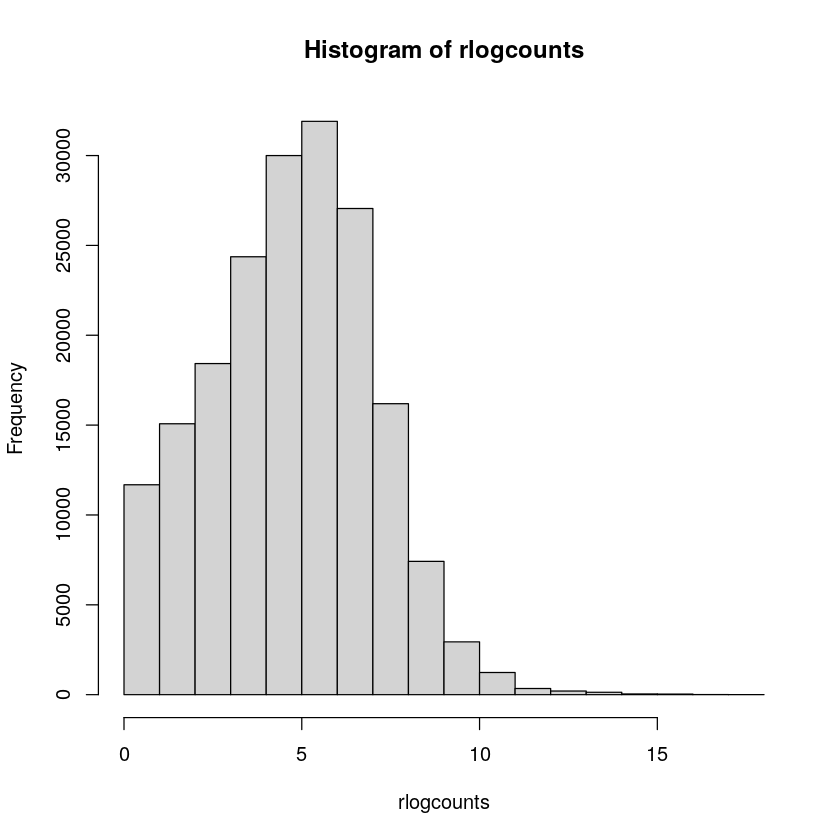

In [14]:
hist(rlogcounts)

Boxplots:

In [15]:
png("boxplot_norm.png")
boxplot(rlogcounts)
dev.off()

png 
  2

Or pairwise comparison plots.

In [16]:
png("pairwise_scatterplots_norm.png")
pairs(rlogcounts)
dev.off()

png 
  2

Compare the plots of the pre-normalized and normalized data to see the effect of normalization.

Notice how the samples in the box plot, and in-group samples in the pair plots display similar distributions.

Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data.

### STEP 7: PCA Plot

We can now begin to produce plots to further analyze the differences between groups.

PCA plots can be an effective way to visualize variation within and between sample sets.

In [28]:
pca_counts <- prcomp(t(rlogcounts))
png("whim_pca.png")
autoplot(pca_counts, data = samples, colour="Treatment",size=3)
dev.off()

png 
  2

Plots can be output as above, or also saved as pdf or image files, as below. Try to navigate and click to the created file, after you run the code.

In [11]:
pdf("data/gene_counts/PCA_Plot.pdf")
autoplot(pca_counts, data = samples, colour="Treatment")
dev.off()

png 
  2

### STEP 8: Contrast Comparisons

Contrast comparisons between two treatment groups can be performed using the deseq2 tool to identify differentially up and down regulated genes.

Using R, these results can be summarized, reordered, and/or trimmed.

In [29]:
#Output the results of comparing WT and WHIM group
res_IAV_CTRL <- results(deseq2Data, contrast=c("Treatment","MUT","WT"))
summary(res_IAV_CTRL)
print("Number of genes under a p value of 0.05")
sum(res_IAV_CTRL$pvalue < 0.05, na.rm=TRUE)
print("Number of genes under a p adjusted value of 0.05")
sum(res_IAV_CTRL$padj < 0.05, na.rm=TRUE)


#deseq2 optionally output some padj values as 'NA' when genecounts meet certain criteria
#that criteria can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA
#for practical uses, one could replace the NA values with '1', essentially NA values not significant.
res_IAV_CTRL$padj[is.na(res_IAV_CTRL$padj)] <- 1


out of 23381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 202, 0.86%
LFC < 0 (down)     : 184, 0.79%
outliers [1]       : 1, 0.0043%
low counts [2]     : 10878, 47%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Number of genes under a p value of 0.05"


[1] 1777

[1] "Number of genes under a p adjusted value of 0.05"


[1] 219

### STEP 9: Annotating and Exporting Results

These differentially expressed genes can be annotated and exported.

Combining gene counts with gene annotation isn't always simple, and will vary heavily depending on the annotation file itself.

For example, when merging genecounts by 'gene id' with feature tables from NCBI's assembly database, its very common to have duplicate rows, as a single 'gene id' may match to multiple features. 

Depending on how you want to use your annotated results, you may decide to further reformat your table in whatever suits your further analysis best, for instance by downloading and using a spreadsheet editor.

Because the transcript table for m chelonae we have here is so simple, and contains essentially only one 'CDS' or '..RNA' feature for every gene identifier we are using, it is easy for us to reformat it here in the way we want just using R code. However, it is important to note that, again, this is very often not the case, and reformatting will vary depending on both the annotation file itself, and what that annotation file will be used for.

In [30]:
system("gsutil cp gs://hon_350/reference/biomart_GRCz11_annotation.txt data/reference/", intern=TRUE)

#read-in the annotation file (see extended tutorial for more info on how to get annotation files) and store it into a variable.
annotation <- read.table("data/reference/biomart_GRCz11_annotation.txt", header=TRUE,sep='\t', quote="\"",comment.char = "")

#put the previous deseq results into an easier to manipulate data.frame format
results <- data.frame(res_IAV_CTRL)

#merge the annotation with the deseq2 contrast comparison table
results.annot <- merge(results,annotation,by.x=0,by.y=1,all.x=TRUE)


#labeling the columns properly after the merge
colnames(results.annot)[1] <- 'Gene_stable_ID'

#write out the file
write.table(results.annot,"data/gene_counts/24hrs_CTRL_IAV_DESeq2_annot.txt",row.names=FALSE,sep="\t")

head(results.annot)

character(0)

,Gene_stable_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.description
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSDARG00000000001,13.29456,0.174587923,0.3941145,0.442987767,0.657774583,1.00000000,slc35a5,solute carrier family 35 member A5 [Source:NCBI gene;Acc:368418]
2,ENSDARG00000000002,50.00177,-0.351703192,0.2168393,-1.621953324,0.104813343,0.60930312,ccdc80,coiled-coil domain containing 80 [Source:NCBI gene;Acc:368419]
3,ENSDARG00000000018,81.80772,-0.001347082,0.1829983,-0.007361171,0.994126688,0.99934193,nrf1,nuclear respiratory factor 1 [Source:NCBI gene;Acc:64604]
4,ENSDARG00000000019,256.71348,0.022143663,0.1297546,0.170658009,0.864492682,0.98022458,ube2h,"ubiquitin-conjugating enzyme E2H (UBC8 homolog, yeast) [Source:ZFIN;Acc:ZDB-GENE-030616-67]"
5,ENSDARG00000000068,53.69485,0.132869173,0.2179671,0.609583554,0.542137709,0.91434963,slc9a3r1a,SLC9A3 regulator 1a [Source:ZFIN;Acc:ZDB-GENE-031006-7]
6,ENSDARG00000000069,150.64439,0.440058588,0.1460032,3.014032914,0.002577998,0.09028049,dap,death-associated protein [Source:ZFIN;Acc:ZDB-GENE-000511-3]


In [16]:
#upload annotated file to google cloud
system("gsutil cp data/gene_counts/24hrs_CTRL_IAV_DESeq2_annot.txt gs://hon_350/24hours_results/", intern=TRUE)


character(0)

### STEP 10: More Plots and Clustering Data

Finally, although several other different kind of analysis can be done, it is common to plot the results of differential gene expression analysis in forms such as volcano, MA, and heatmaps. These plots help one to further examine the output list of differentially expressed genes in different ways, and potentially identify or further investigate candidate gene(s).

png 
  2

png 
  2

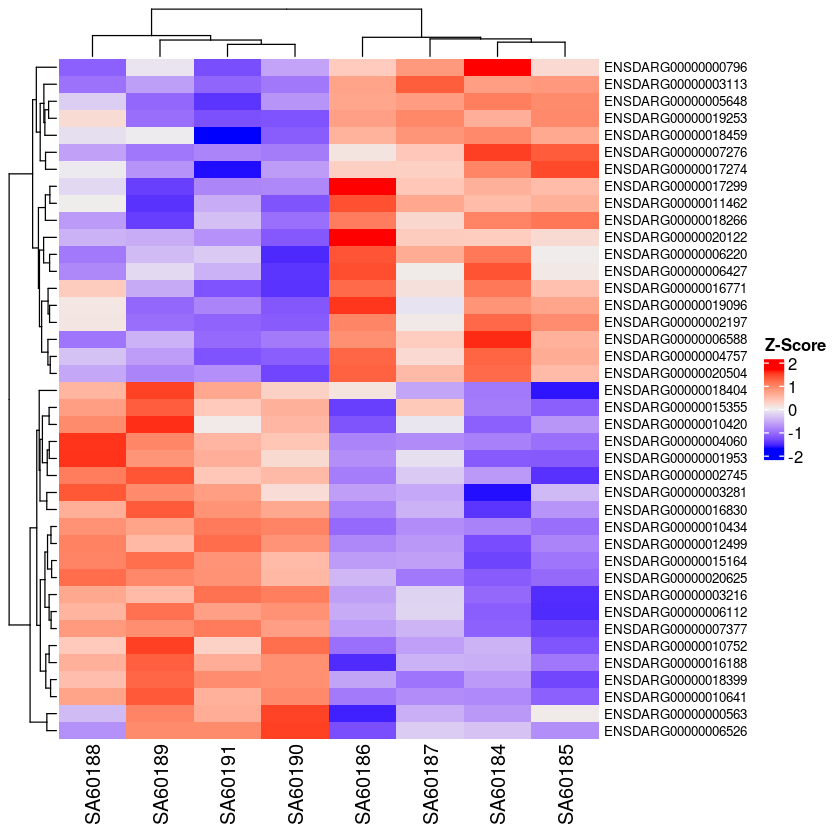

In [32]:
#volcano and ma plots can be used to visualize significant differences in gene expression
results_volc_df <- results.annot
png("whim_volcano_plot.png")
EnhancedVolcano(results_volc_df,
    lab = results_volc_df[,1],
    x = 'log2FoldChange',
    y = 'padj')
dev.off()

#ma plot
png("whim_MA_plot.png")
plotMA(res_IAV_CTRL)
dev.off()


#heatmaps can used to look at clustering and expression of various gene lists.
filtered_res <- results.annot %>% filter(padj < 0.05)
filtered_res_counts <- subset(rlogcounts, rownames(rlogcounts) %in% filtered_res[,1])
filtered_res_counts = t(scale(t(filtered_res_counts)))
#showing 40 of the genes under padj 0.05 (in no order)
Heatmap(filtered_res_counts[1:40,], name = "Z-Score", row_names_gp = gpar(fontsize = 8))